### KL Divergence Estimation

---

This notebook explores how to compute and estimate the KL Divergence.

In [1]:
%matplotlib inline

import scipy.stats as ss
import numpy as np
from approxposterior import utility as ut, gpUtils

import matplotlib as mpl
import matplotlib.pyplot as plt

#Typical plot parameters that make for pretty plots
mpl.rcParams['figure.figsize'] = (9,8)
mpl.rcParams['font.size'] = 25.0

## for Palatino and other serif fonts use:
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)

/Users/dflemin3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**Compute KL Divergence for two normal distributions using scipy's entropy function**

---

This method is quick and easy when you have 1D arrays representing the two pdfs.

In [2]:
# Normal distributions!
num = 1000
x = np.linspace(-5, 5, num)

# Make two different normal pdfs
pDiff = ss.norm.pdf(x, loc=1.2, scale=1)
qDiff = ss.norm.pdf(x, loc=-1.2, scale=1)

# Estimate KL divergence: Should be rather non-zero
klDiff = ss.entropy(pDiff, qDiff)
print(klDiff)

2.8793125302864415


In [3]:
# Make two slightly different normal pdfs
pClose = ss.norm.pdf(x, loc=0, scale=1)
qClose = ss.norm.pdf(x, loc=0.2, scale=0.8)

# Estimate KL divergence: should be close to zero
klClose = ss.entropy(pClose, qClose)
print(klClose)

0.08935292452858988


In [4]:
# Use the same pdf now
p = ss.norm.pdf(x, loc=0, scale=1)

# Estimate KL divergence: should be zero
klSame = ss.entropy(p,p)
print(klSame)

0.0


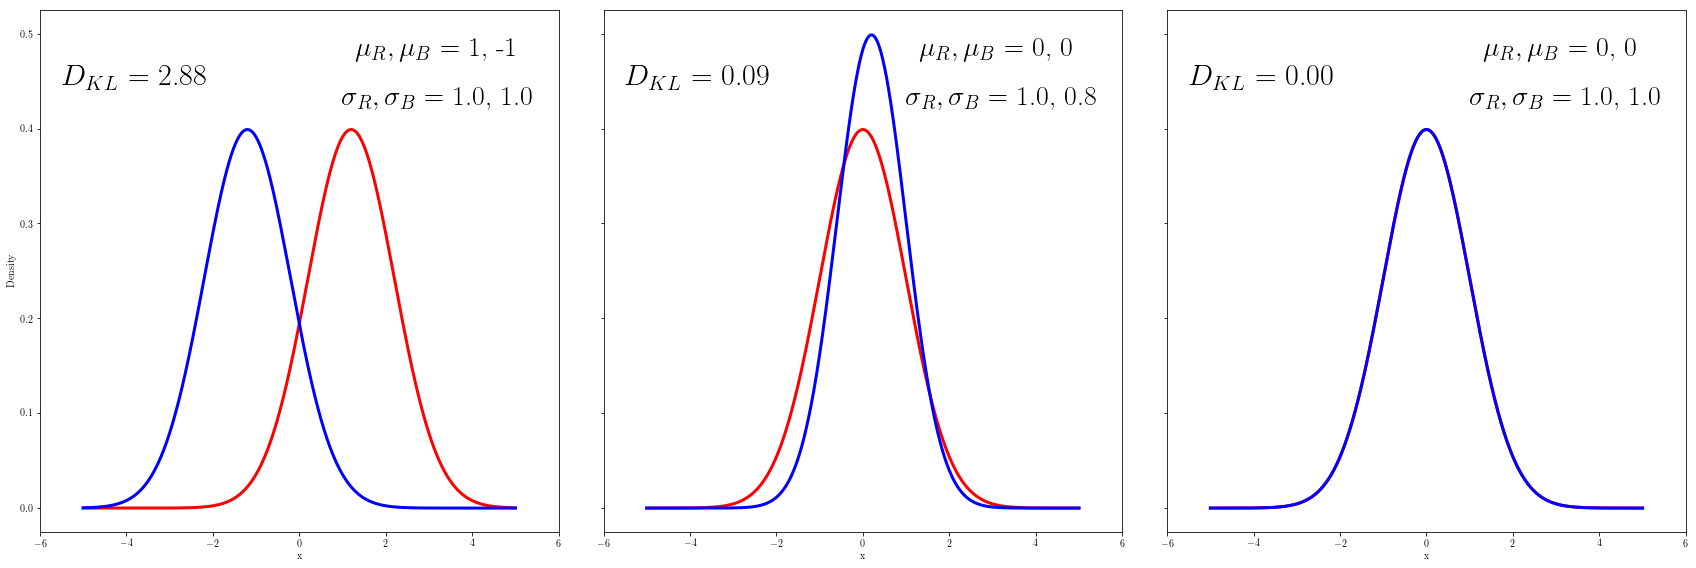

In [5]:
# Plot the distributions and the KL divergence!
fig, axes = plt.subplots(ncols=3, figsize=(24,8), sharey=True)

# Listify the quantities
ps = [pDiff, pClose, p]
qs = [qDiff, qClose, p]
kls = [klDiff, klClose, klSame]
mus = [[1.2,-1.2], [0,0.2], [0,0]]
sigs = [[1,1], [1,0.8], [1,1]]

# Plot the data with annotations
for ii in range(len(axes)):
    axes[ii].plot(x, ps[ii], 'r-', lw=3)
    axes[ii].plot(x, qs[ii], 'b-', lw=3)

    # Add KL Divergence
    axes[ii].text(-5.5, 0.45, "$D_{KL}$ = %.2lf" % kls[ii],
              ha="left", va="center", size=30, color="k",
              bbox=dict(boxstyle="square", fc="w", ec="none"))

    # Add Gaussian Parameters
    axes[ii].text(1.3, 0.48, "$\mu_R, \mu_B$ = %.0lf, %.0lf" % (mus[ii][0],mus[ii][1]),
              ha="left", va="center", size=28, color="k",
              bbox=dict(boxstyle="square", fc="w", ec="none"))
    axes[ii].text(1.0, 0.43, "$\sigma_R, \sigma_B$ = %.1lf, %.1lf" % (sigs[ii][0],sigs[ii][1]),
              ha="left", va="center", size=28, color="k",
              bbox=dict(boxstyle="square", fc="w", ec="none"))

# Format all axes
axes[0].set_ylabel("Density")
for ax in axes:
    ax.set_xlabel("x")
    
    ax.set_ylim(-0.025,0.525)
    ax.set_xlim(-6,6)
fig.tight_layout()

**Numerically estimate the KL divergence via samping the distributions**

---

When you have a weird, multi-dimensional pdf, you must turn to numerical methods to get an answer.

Here, we examine the 1st case (left panel of the above figure) to see gauge the performance of our numerical method of estimating the KL divergence. 

In [6]:
# How does it all scale as a function of the number of random samples?
nums = [100, 1000, 10000, 100000]
seeds = [42,1,55,91]
iters = 5

klNum = np.zeros((len(nums), iters))

pKwargs = {"loc": 1.2, "scale": 1}
qKwargs = {"loc" : -1.2, "scale" : 1}

# Wrap the functions
pPdf = ut.functionWrapper(ss.norm.pdf, **pKwargs)
qPdf = ut.functionWrapper(ss.norm.pdf, **qKwargs)

for ii in range(len(nums)):
    # Reset seed for "new" random numbers
    np.random.seed(seeds[ii])
    for jj in range(iters):
        x = ss.norm.rvs(loc=1.2, scale=1, size=nums[ii])
        klNum[ii,jj] = ut.klNumerical(x, pPdf, qPdf)
        
# Compute mean, error of KL divergence numerical estimates
means = np.mean(klNum, axis=1)
stds = np.std(klNum, axis=1)

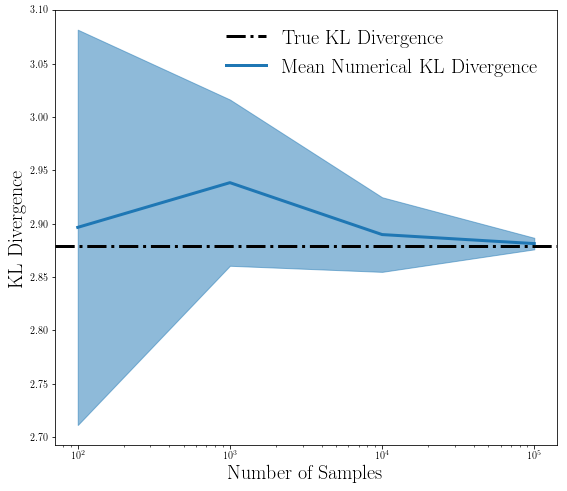

In [7]:
# Plot it!
fig, ax = plt.subplots(figsize=(9,8))

# Truth
ax.axhline(klDiff, ls="-.", lw=3, color="k", label="True KL Divergence")

# Estimate, error envelope at each step
ax.plot(nums, means, lw=3, color="C0", label="Mean Numerical KL Divergence")
ax.fill_between(nums, means - stds, means + stds, alpha=0.5, color="C0")

ax.set_ylabel("KL Divergence", fontsize=20)
ax.legend(loc="upper right", fontsize=20, framealpha=0)

ax.set_xlabel("Number of Samples", fontsize=20)
ax.set_xscale("log")